In [76]:
from utils.cluster import group_kmeans, single_kmeans
from utils.visualize import (
    plot_distortions,
    plot_label_distr,
    plot_return,
    plot_return_box,
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Clustering with data from day i and day i-1

## Read and extract clustering attributes

In [13]:
# read data
READ_PATH = "data/processed/spy_max_221118_train.csv"
df = pd.read_csv(READ_PATH)

# save clustering attributes to a new df
use_cols = ['open/open_i-1', 'high/high_i-1', 'low/low_i-1', 'close/close_i-1',
            'volume/volume_i-1']
X = df[use_cols]
X.head()

,open/open_i-1,high/high_i-1,low/low_i-1,close/close_i-1,volume/volume_i-1
0,0.995400,0.998656,1.001282,1.001137,0.694338
1,1.002768,1.008964,1.005330,1.008605,2.229417
2,0.986817,0.987202,0.990846,0.980340,0.904607
3,0.994090,0.998302,0.999909,1.005604,0.990637
4,0.998198,0.992169,0.979762,0.973735,1.227363


## Perform clustering and plot return distribution

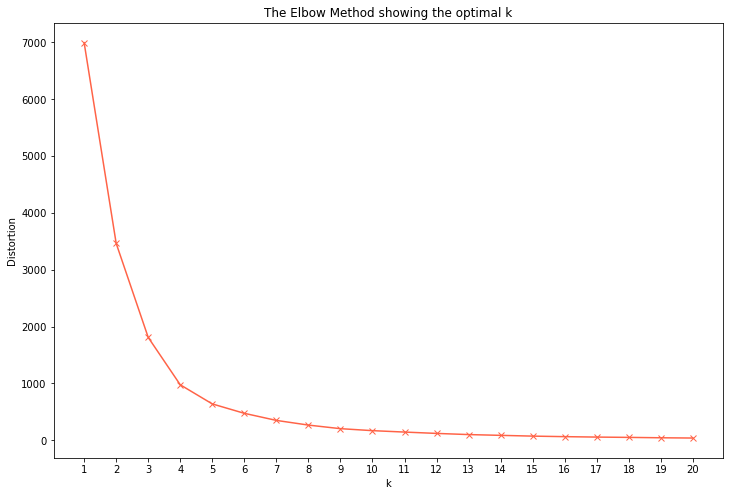

In [7]:
# perform kmeans
k_upper = 20
distortions = group_kmeans(k_upper, X)
# k=4 is the optimal k with elbow method
fig_size = (12, 8)
file_name = 'kmeans_elbow_day_i_i-1_no_norm.png'
plot_distortions(k_upper, distortions, fig_size, file_name)

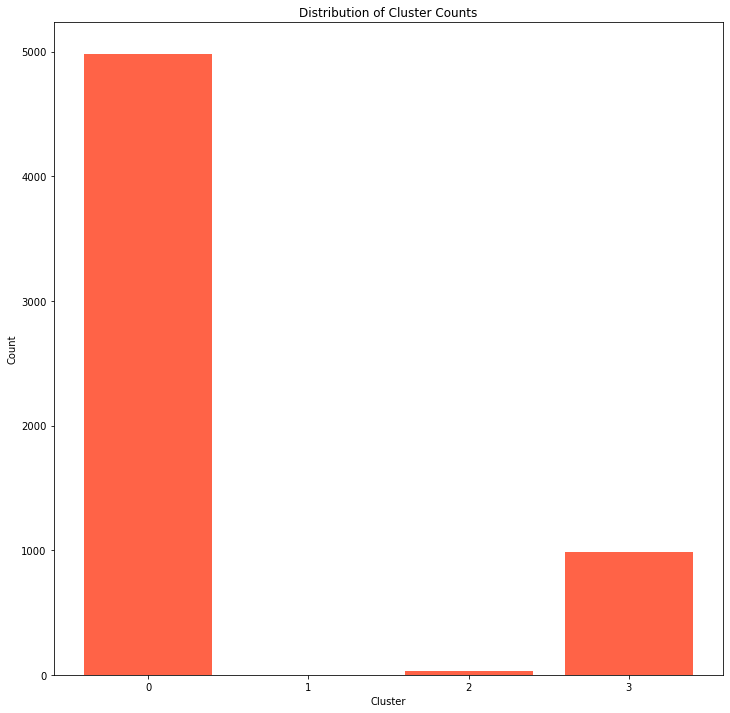

In [20]:
# perform kmeans with optimal k=4
opt_k = 4
model = single_kmeans(opt_k, X)
# plot distribution of labels
file_name = 'kmeans_day_i_i-1_no_norm_cluster_distr.png'
plot_label_distr(model.labels_, fig_size, file_name)
# note:the clusters are very imbalanced -> maybe need a way to improve later

## Perform clustering with standardized data and plot return
* variance of volume/volume_i-1 is much larger than the rest
* it could be a good idea to standardize data before clustering

In [9]:
# variance of attributes feeding into the clustering algorithm
X.var()

open/open_i-1        0.000139
high/high_i-1        0.000089
low/low_i-1          0.000128
close/close_i-1      0.000141
volume/volume_i-1    1.165050
dtype: float64

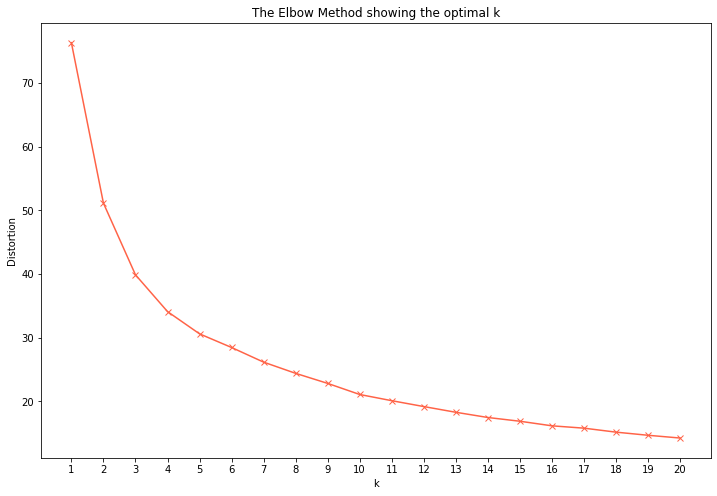

In [15]:
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)
# perform kmeans
k_upper = 20
distortions = group_kmeans(k_upper, X_minmax)
# k=4 is the optimal k with elbow method
fig_size = (12, 8)
file_name = 'kmeans_day_i_i-1_elbow.png'
plot_distortions(k_upper, distortions, fig_size, file_name)

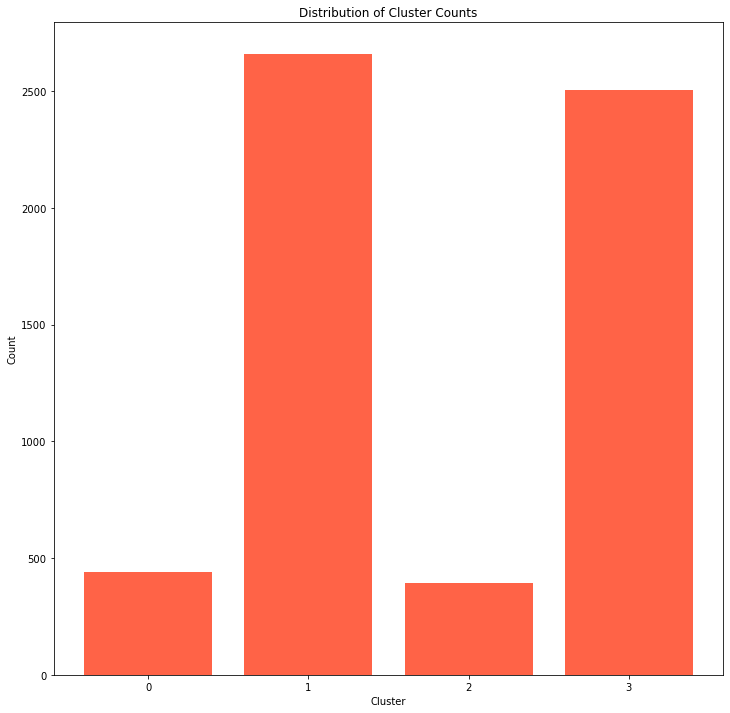

In [21]:
# perform kmeans with optimal k=4
opt_k = 4
model = single_kmeans(opt_k, X_minmax)
# plot distribution of labels
file_name = 'kmeans_day_i_i-1_clusters.png'
plot_label_distr(model.labels_, fig_size, file_name)
# note:the clusters are still somehow imbalanced but much better

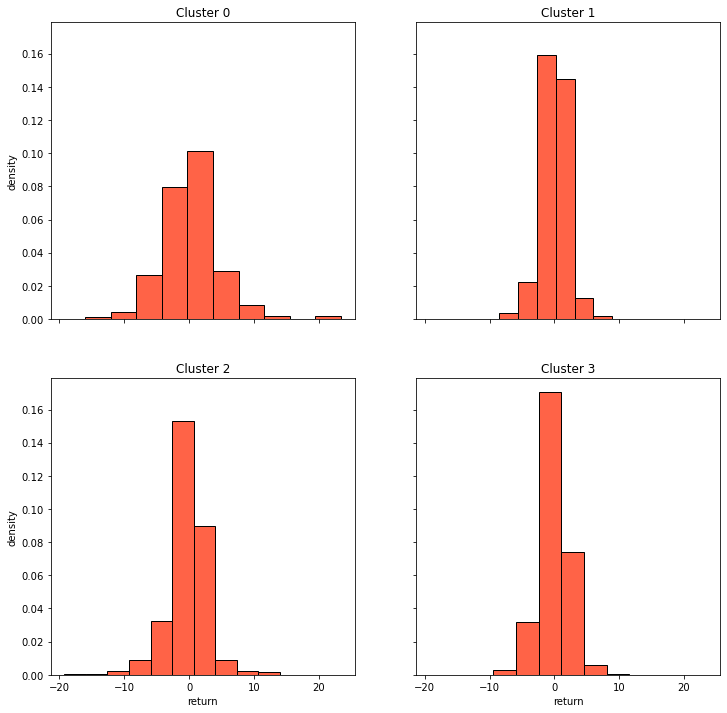

In [22]:
nrows, ncols = 2, 2
fig_size = (12, 12)
file_name = 'kmeans_day_i_i-1_returns.png'
plot_return(model.labels_, np.array(df['return_i+1']), opt_k, nrows, ncols, fig_size, file_name)

## Results analysis on train and test data

In [49]:
# find mean and variance of each cluster return: training
for cluster_num in range(opt_k):
    cluster_ind = np.argwhere(labels==cluster_num)
    return_cluster = np.array(df['return_i+1'])[cluster_ind]
    return_cluster_str = str(round(return_cluster.mean(), 4))
    var_cluster_str = str(round(return_cluster.std(), 4))
    result_str = 'cluster' + str(cluster_num) + ' return: ' + \
    'mean ' + return_cluster_str + ', '\
    'std ' + var_cluster_str
    print(result_str)

cluster0 return: mean 0.3751, std 4.4438
cluster1 return: mean 0.0116, std 1.9694
cluster2 return: mean -0.2178, std 3.2012
cluster3 return: mean 0.0091, std 2.2615


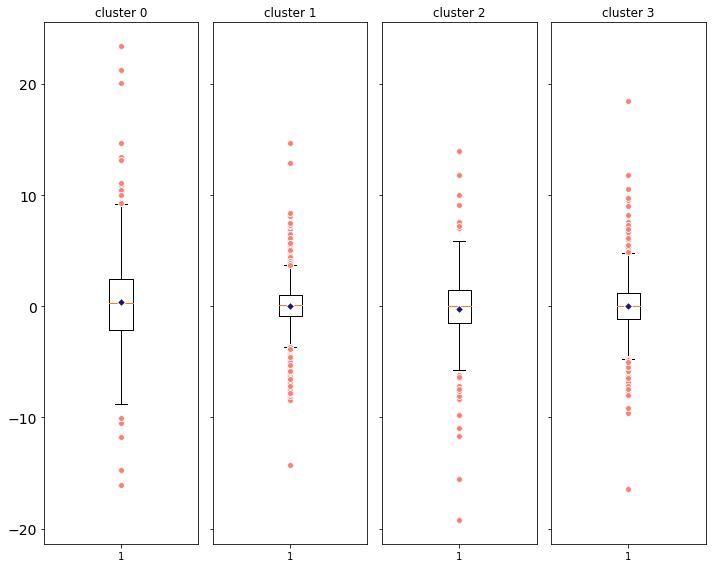

In [87]:
# box plot for training returns 
fig_size = (10, 8)
file_name = 'kmeans_day_i_i-1_returns_boxplot.png'
plot_return_box(model.labels_, np.array(df['return_i+1']), opt_k, fig_size, file_name)

In [ ]:
# predict cluster of test data and draw distribution

In [ ]:
# draw qq plot (train data on x and test data on y to see if they are close enough) for each cluster

# Clustering with data from day i, day i-1, and day i-2

## Add attributes related to day i-2

In [4]:
# day i-2 attributes
# open, high, low, close, volume from 2 days before
df['open_i-2'] = df['open'].shift(2)
df['high_i-2'] = df['high'].shift(2)
df['low_i-2'] = df['low'].shift(2)
df['close_i-2'] = df['close'].shift(2)
df['volume_i-2'] = df['volume'].shift(2)
df.dropna(inplace=True)

# ratio between day i-1 and i-2
df['open_i-1/open_i-2'] = df['open_i-1']/df['open_i-2']
df['high_i-1/high_i-2'] = df['high_i-1']/df['high_i-2']
df['low_i-1/low_i-2'] = df['low_i-1']/df['low_i-2']
df['close_i-1/close_i-2'] = df['close_i-1']/df['close_i-2']
df['volume_i-1/volume_i-2'] = df['volume_i-1']/df['volume_i-2']


# save clustering attributes to a new df
use_cols = ['open/open_i-1', 'high/high_i-1', 'low/low_i-1', 'close/close_i-1',
            'volume/volume_i-1', 'open_i-1/open_i-2', 'high_i-1/high_i-2', 'low_i-1/low_i-2',
            'close_i-1/close_i-2', 'volume_i-1/volume_i-2']
X = df[use_cols]
#X.head()
df.head()

,date,open,high,low,close,volume,open_i+1,close_i+1,return_i+1,open_i-1,...,open_i-2,high_i-2,low_i-2,close_i-2,volume_i-2,open_i-1/open_i-2,high_i-1/high_i-2,low_i-1/low_i-2,close_i-1/close_i-2,volume_i-1/volume_i-2
3,1993-02-03 00:00:00-05:00,25.604302,25.856561,25.586284,25.838543,529400,25.928637,25.946655,0.175122,25.496205,...,25.352041,25.514208,25.352041,25.514208,480500.0,1.005686,1.002825,1.003554,1.002119,0.418939
4,1993-02-04 00:00:00-05:00,25.928637,26.000711,25.640341,25.946655,531500,25.928637,25.928637,0.000000,25.604302,...,25.496205,25.586298,25.442150,25.568279,201300.0,1.004240,1.010563,1.005665,1.010570,2.629906
5,1993-02-05 00:00:00-05:00,25.928637,25.982692,25.784488,25.928637,492100,25.928637,25.928637,0.000000,25.928637,...,25.604302,25.856561,25.586284,25.838543,529400.0,1.012667,1.005575,1.002113,1.004184,1.003967
6,1993-02-08 00:00:00-05:00,25.928637,26.018729,25.892600,25.928637,596100,25.838538,25.748446,-0.878661,25.928637,...,25.928637,26.000711,25.640341,25.946655,531500.0,1.000000,0.999307,1.005622,0.999306,0.925870
7,1993-02-09 00:00:00-05:00,25.838538,25.838538,25.694390,25.748446,122100,25.748461,25.784498,0.352694,25.928637,...,25.928637,25.982692,25.784488,25.928637,492100.0,1.000000,1.001387,1.004193,1.000000,1.211339


In [ ]:
X.var()

## Perform clustering with standardization and plot return

In [ ]:
X_minmax = min_max_scaler.fit_transform(X)
# perform kmeans
k_upper = 20
distortions = group_kmeans(k_upper, X_minmax)
# k=4 is the optimal k with elbow method
fig_size = (12, 8)
file_name = 'kmeans_day_i_i-2_elbow.png'
plot_distortions(k_upper, distortions, fig_size, file_name)

In [ ]:
# perform kmeans with optimal k=4
opt_k = 5
labels = single_kmeans(opt_k, X_minmax)
# plot distribution of labels
file_name = 'kmeans_day_i_i-2_clusters.png'
plot_label_distr(labels, fig_size, file_name)
# note:the clusters are still somehow imbalanced

In [ ]:
nrows, ncols = 2, 3
fig_size = (18, 12)
file_name = 'kmeans_day_i_i-2_returns.png'
plot_return(labels, np.array(df['return_i+1']), opt_k, nrows, ncols, fig_size, file_name)